# **amir mohammad ramezan naderi- 610398126**

## Table of contents
- [1- imports](#1)
- [2- problem](#2)
- [3- preprocessing](#3)
- [4- autoencoder](#4)
- [5- model on denoised images](#5)
- [6- model on original images](#6)
- [7- evaluation](#7)
- [8- Kfold](#8)

<a name='1'></a>
# 1- imports

first, we import some libraries and functions which we need to do preprocess and make models.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow

import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D

<a name='2'></a>
# 2- problem

The main product of grapevines is grapes that are consumed fresh or processed. In addition, grapevine leaves are harvested once a year as a by-product. The species of grapevine leaves are important in terms of price and taste. In this study, deep learning-based classification is conducted by using images of grapevine leaves. For this purpose, images of 500 vine leaves belonging to 5 species were taken with a special self-illuminating system.
<br>
now we are trying to classify these images using pre-trained deep learning models and some fine-tuning.

<a name='3'></a>
# 3- preprocessing

first we get images from directory by tensorflow.keras.preprocessing.image_dataset_from_directory() function. the size of these images will be (224 * 224 * 3) and the batch_size is 16. there are 500 images, the size of the trainig dataset is 320, the validation dataset size is 80 and the test dataset size is 100.

In [3]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

directory = "dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

# val_dataset = image_dataset_from_directory(directory,
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE,
#                                              image_size=IMG_SIZE,
#                                              validation_split=0.15,
#                                              subset='validation',
#                                              seed=42)

test_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


then we visualize some of the leaves images with their corresponding labels.

2022-08-04 15:14:34.648560: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


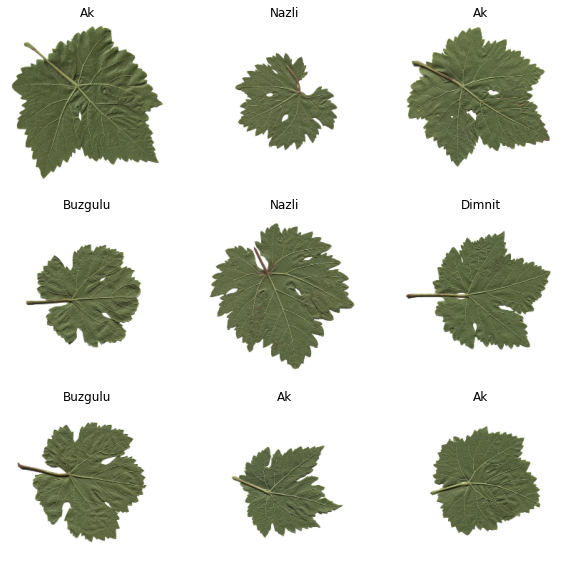

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

making train/validation/test datasets:

In [4]:
X_train = np.empty((0,224, 224, 3))
y_train = np.array([])
for x, y in train_dataset:
    X_train = np.concatenate([X_train, x.numpy()/255.])
    y_train = np.concatenate([y_train, y.numpy()])

2022-08-05 21:07:43.097999: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
X_train_target, X_val, y_train_target, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train_target.shape, X_val.shape)

(320, 224, 224, 3) (80, 224, 224, 3)


In [6]:
X_test = np.empty((0,224, 224, 3))
y_test = np.array([])
for x, y in test_dataset:
    X_test = np.concatenate([X_test, x.numpy()/255.])
    y_test = np.concatenate([y_test, y.numpy()])

in this part we define a data augmeter function which does random flipping, random rotating and random zooming. later this function will be applied to the **train/validation dataset**.

In [7]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.3))
    data_augmentation.add(RandomZoom(0.5,0.2))
    # data_augmentation.add(RandomTranslation(0.2,0.2))
    return data_augmentation

see some augmented images:

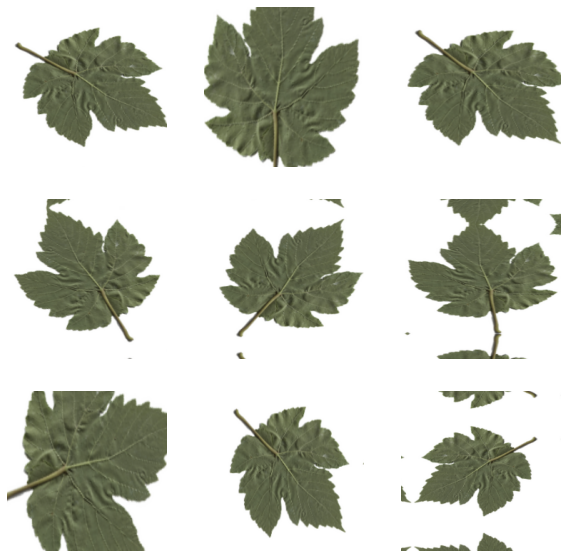

In [61]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[10]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

<a name='4'></a>
# 4- autoencoder

in this step we make a model for autoencoder. Autoencoder is an unsupervised artificial neural network that is trained to copy its input to output. In the case of image data, the autoencoder will first encode the image into a lower-dimensional representation, then decodes that representation back to the image. Encoder-Decoder automatically consists of the following two structures:
<br>
**1- The encoder:** This network downsamples the data into lower dimensions.
<br>
**2- The decoder:** This network reconstructs the original data from the lower dimension representation.
<br>
The lower dimension (i.e, output of encoder network) representation is usually known as latent space representation.
<br>
the input layer for this model has the shape (224 * 224 * 3), we add some convolutional layers with activation='relu' and padding='same' for the encoder part. then we add some  transpose convolutional layers(Conv2DTranspose) with activation='relu' and padding='same' for the decoder part. these layers upsamples the data so at the end we end up with a (224 * 224 * 3) output which has the same size like its first layer. as you can see in the summary of the model, the number of parameters for train is 29,507.

In [53]:
inputs = layers.Input(shape=(224, 224, 3))

# Encoder
# x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# # Decoder
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy")
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 112, 112, 32)     9248

now we fit the encoder to the test/validation set for 20 epochs and batch_size 16. the optimizer for this fitting is adam with learning rate = 0.001 and the loss function is set to binary_crossentropy.

In [54]:
autoencoder.fit(X_train,X_train, epochs=20,shuffle = True, batch_size = 16)

Epoch 1/20
25/25 [==============================] - 10s 381ms/step - loss: 0.5053
Epoch 2/20
25/25 [==============================] - 9s 376ms/step - loss: 0.3685
Epoch 3/20
25/25 [==============================] - 10s 382ms/step - loss: 0.2844
Epoch 4/20
25/25 [==============================] - 9s 368ms/step - loss: 0.2382
Epoch 5/20
25/25 [==============================] - 9s 365ms/step - loss: 0.2310
Epoch 6/20
25/25 [==============================] - 9s 366ms/step - loss: 0.2290
Epoch 7/20
25/25 [==============================] - 9s 366ms/step - loss: 0.2277
Epoch 8/20
25/25 [==============================] - 9s 369ms/step - loss: 0.2266
Epoch 9/20
25/25 [==============================] - 9s 370ms/step - loss: 0.2256
Epoch 10/20
25/25 [==============================] - 9s 370ms/step - loss: 0.2247
Epoch 11/20
25/25 [==============================] - 9s 368ms/step - loss: 0.2238
Epoch 12/20
25/25 [==============================] - 9s 368ms/step - loss: 0.2230
Epoch 13/20
25/25 [====

now construct new images for the trainig dataset by autoencoder.predict() function:

In [55]:
predicts = autoencoder.predict(X_train)

by this we generate 400 images of size (224,224,3) with range of (0, 1)

In [56]:
print('the shape of autoencoder prediction is: ', predicts.shape)

the shape of autoencoder prediction is:  (400, 224, 224, 3)


now we compare the original image and the denoised image derived from autoencoder:

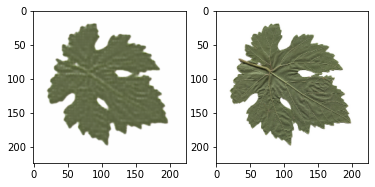

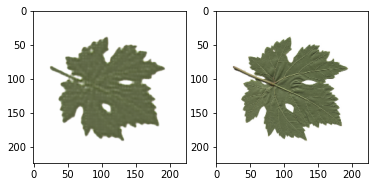

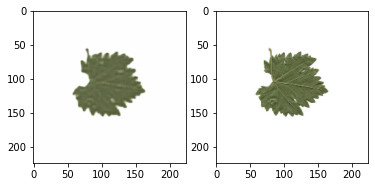

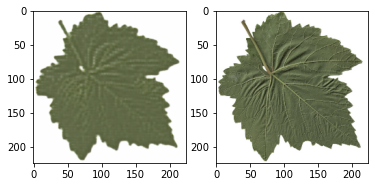

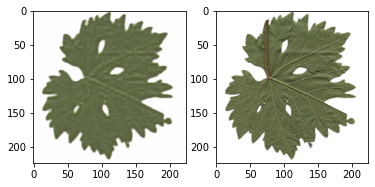

In [57]:
for i in range(5):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(predicts[i])
    axarr[1].imshow(X_train[i])

as you can see the original image is better than the reconstructed image. later we see the accuracy of these images.
<br>
now we display some images of denoised images for fun:

In [58]:
def display(array1):
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]

    plt.figure(figsize=(10, 7))
    for i, image1 in enumerate(images1):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(224, 224,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

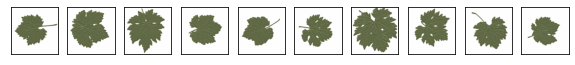

In [59]:
display(predicts)

<a name='5'></a>
# 5- model on denoised images

in this project, we are using **xception** deep learning model.<br>
this is an inception modules in convolutional neural networks as being an intermediate step in-between regular convolution and the depthwise separable convolution operation (a depthwise convolution followed by a pointwise convolution)
<br>so now we set leaning rate schedule configuration for this model:

In [62]:
EPOCHS = 13
LR_START = 0.00001
LR_MAX = 0.0001 * 0.6
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .5

In [63]:
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

Learning rate schedule: 1e-05 to 6e-05 to 1.08e-05


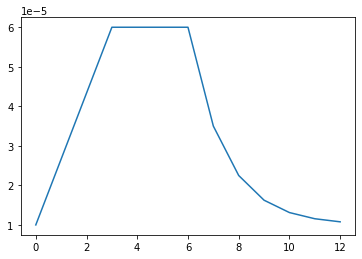

In [64]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

**this LearningRateScheduler is given from Practical Machine Learning for Computer Vision(book)**

now we construct our main model:
<br>
firt we get the pre-trained xception model from tf.keras.applications with input shape of (224,224,3). this model is trained on imageNet dataset which has 1000 class.
<br>
at first we set all the 132 layers of xception 'trainable' so all the wights will be updated. after augmeting the data in the model, we set our 23m parameter xception model to those augmented images. then we use GlobalAveragePooling2D layer and drop out layer with parameter 0.5, then we flatten the units(neurons), at the end we pass these 2048 weights to the softmax layer with 5 units.
<br>
you can see the summary of our model later:

In [98]:
base_model = tf.keras.applications.xception.Xception(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

input_shape = (224,224,3)

inputs = tf.keras.Input(shape=input_shape) 
x = data_augmenter()(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x) 
x = layers.GlobalAveragePooling2D()(x) 
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(100, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(100, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.BatchNormalization()(x)

outputs = layers.Dense(5,activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [99]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

we construct our (X, y) pair for the fitting part:

In [67]:
denoise_train = autoencoder.predict(X_train)
# denoise_val = autoencoder.predict(X_val)

In [68]:
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')
y_val = y_val.astype('uint8')

we compile the model with **adam** optimizer, **sparse_categorical_crossentropy** loss function and **accuracy** for metrics.
<br>
now we fit the model on trainig dataset, using validation dataset with epoch = 13 and batch size = 16. we got:

In [100]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    x=denoise_train*255.,
    y=y_train,
    validation_data=(X_val*255., y_val),
    # validation_data = val_dataset,
    callbacks = [lr_callback],
    epochs = EPOCHS,
    batch_size=16
)


Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/13
25/25 [==============================] - 63s 2s/step - loss: 1.6404 - accuracy: 0.2050 - val_loss: 1.5978 - val_accuracy: 0.2125 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 2.6666666666666667e-05.
Epoch 2/13
25/25 [==============================] - 62s 2s/step - loss: 1.5719 - accuracy: 0.2775 - val_loss: 1.4888 - val_accuracy: 0.4125 - lr: 2.6667e-05

Epoch 00003: LearningRateScheduler setting learning rate to 4.3333333333333334e-05.
Epoch 3/13
25/25 [==============================] - 61s 2s/step - loss: 1.4155 - accuracy: 0.4575 - val_loss: 1.3606 - val_accuracy: 0.4500 - lr: 4.3333e-05

Epoch 00004: LearningRateScheduler setting learning rate to 6e-05.
Epoch 4/13
25/25 [==============================] - 64s 3s/step - loss: 1.2085 - accuracy: 0.5650 - val_loss: 1.1819 - val_accuracy: 0.6250 - lr: 6.0000e-05

Epoch 00005: LearningRateScheduler setting learning rate to 6e-05

so we end up with 68% accuracy on validation dataset and 84.5% accuracy on trainig dataset. we plot loss based on epoch in below:

<AxesSubplot:>

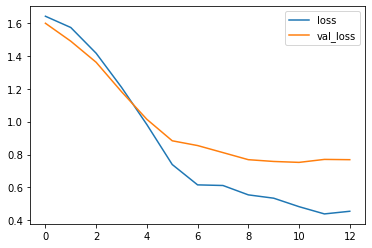

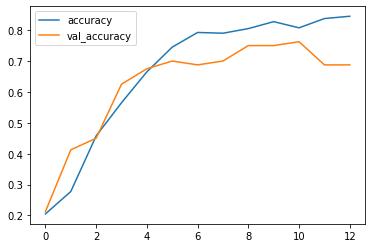

In [102]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

now we fine tune the layers. we do this work by appling trainable method on layers of xception model. there are 132 layers in xception model.
<br>we set trainable mode of our first 100 layers to 'False' and set the rest of our layers to 'True'. by this work, just the weights of the last 32 layers will be updated. you can see the code in below:

In [103]:
base_model2 = model.layers[4]
base_model2.trainable = True

fine_tune_at = 100

for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False

In [104]:
print("Number of layers in the model: ", len(base_model2.layers))

Number of layers in the model:  132


now in fine tuning part, we set the learning rate of our adam optimizer to 0.0001. we set early stopping call back function in fitting part, then we fit the model 15 more epochs. you can see the result later:

In [105]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics= ['accuracy']
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics=metrics)

In [106]:
Checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_model_xception_autoencoder.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [Checkpoint_cb, early_stopping]

In [108]:
initial_epochs = 13
new_epochs = 15
total_epochs =  initial_epochs + new_epochs

history_fine = model.fit(x=denoise_train*255., y=y_train,validation_data=(X_val*255., y_val),
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=callbacks)

Epoch 13/28
13/13 [==============================] - 25s 2s/step - loss: 0.3538 - accuracy: 0.8800 - val_loss: 0.3643 - val_accuracy: 0.8625
Epoch 14/28
13/13 [==============================] - 25s 2s/step - loss: 0.3261 - accuracy: 0.8850 - val_loss: 0.3890 - val_accuracy: 0.8750
Epoch 15/28
13/13 [==============================] - 25s 2s/step - loss: 0.3032 - accuracy: 0.8800 - val_loss: 0.3198 - val_accuracy: 0.8875
Epoch 16/28
13/13 [==============================] - 26s 2s/step - loss: 0.3322 - accuracy: 0.8775 - val_loss: 0.2533 - val_accuracy: 0.9375
Epoch 17/28
13/13 [==============================] - 25s 2s/step - loss: 0.3206 - accuracy: 0.8850 - val_loss: 0.2481 - val_accuracy: 0.9125
Epoch 18/28
13/13 [==============================] - 25s 2s/step - loss: 0.2207 - accuracy: 0.9150 - val_loss: 0.2104 - val_accuracy: 0.9250
Epoch 19/28
13/13 [==============================] - 25s 2s/step - loss: 0.2411 - accuracy: 0.9200 - val_loss: 0.1908 - val_accuracy: 0.9375
Epoch 20/28
1

as you can see, we end up with 96.25% accuracy on validation dataset and 92.75% accuracy on trainig dataset. we plot loss based on epoch in below:

<AxesSubplot:>

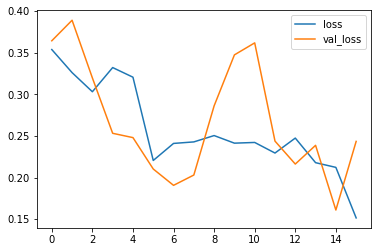

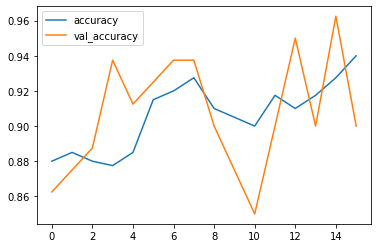

In [109]:
history_df = pd.DataFrame(history_fine.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

now we load the best model by model.load_weights():

In [110]:
model.load_weights('save_model_xception_autoencoder.h5')

at the end we test our model on test set which is not encoded:

In [111]:
model.evaluate(X_test*255., y_test)

4/4 [==============================] - 3s 769ms/step - loss: 0.7486 - accuracy: 0.7800


[0.7486359477043152, 0.7799999713897705]

the loss for this evaluation is 0.7 and the accuracy is 78% which is not good.
<br>
the reason of this accuracy is because of the bad encoding. the original images are pure enough to do the training and we don't need that image deenoising with autoencoder. i made a lot of encoder/decoder architucture with different kernels, but the result wasn't satisfying.

<a name='6'></a>
# 6- model on original images

so i think we should stop image denoising and do the training with our original images(fitting without autoencoders). so first we modify our model:

In [15]:
base_model = tf.keras.applications.xception.Xception(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

input_shape = (224,224,3)

inputs = tf.keras.Input(shape=input_shape) 
x = data_augmenter()(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x) 
x = layers.GlobalAveragePooling2D()(x) 
x = layers.Flatten()(x)
outputs = layers.Dense(5,activation = 'softmax')(x)

final_model = tf.keras.Model(inputs, outputs)

**we just pull off the dropoutlayer**

this time we fit this model on the original images which is not denoised:

In [122]:
final_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = final_model.fit(
    x=X_train_target*255.,
    y=y_train_target,
    validation_data=(X_val*255., y_val),
    # validation_data = val_dataset,
    callbacks = [lr_callback],
    epochs = EPOCHS,
    batch_size=16
)


Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/13
20/20 [==============================] - 52s 3s/step - loss: 1.6480 - accuracy: 0.2156 - val_loss: 1.6984 - val_accuracy: 0.2875 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 2.6666666666666667e-05.
Epoch 2/13
20/20 [==============================] - 49s 2s/step - loss: 1.5474 - accuracy: 0.3313 - val_loss: 1.6098 - val_accuracy: 0.3750 - lr: 2.6667e-05

Epoch 00003: LearningRateScheduler setting learning rate to 4.3333333333333334e-05.
Epoch 3/13
20/20 [==============================] - 50s 2s/step - loss: 1.3581 - accuracy: 0.5594 - val_loss: 1.3899 - val_accuracy: 0.4250 - lr: 4.3333e-05

Epoch 00004: LearningRateScheduler setting learning rate to 6e-05.
Epoch 4/13
20/20 [==============================] - 53s 3s/step - loss: 1.0691 - accuracy: 0.6625 - val_loss: 1.0634 - val_accuracy: 0.6250 - lr: 6.0000e-05

Epoch 00005: LearningRateScheduler setting learning rate to 6e-05

so we end up with 93.4% accuracy on validation dataset and 86.25% accuracy on trainig dataset.

plotting the loss based on epoch:

<AxesSubplot:>

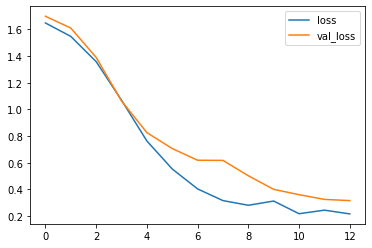

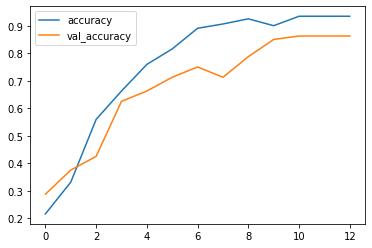

In [123]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

fine tuning like before, this time we train the last 42 layers:

In [124]:
base_model2 = final_model.layers[4]
base_model2.trainable = True

fine_tune_at = 90

for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False

set the optimizer, loss function and callbacks like before:

In [126]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics= ['accuracy']
final_model.compile(loss="sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics=metrics)

Checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_model_xception_without_autoencoder.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [Checkpoint_cb, early_stopping]

fit for more 30 epochs:

In [127]:
initial_epochs = 13
new_epochs = 30
total_epochs =  initial_epochs + new_epochs

history_fine = final_model.fit(x=X_train_target*255., y=y_train_target,validation_data=(X_val*255., y_val),
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=callbacks)

Epoch 13/43
10/10 [==============================] - 23s 2s/step - loss: 0.2262 - accuracy: 0.9375 - val_loss: 0.3046 - val_accuracy: 0.8750


/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 14/43
10/10 [==============================] - 23s 2s/step - loss: 0.2080 - accuracy: 0.9438 - val_loss: 0.3027 - val_accuracy: 0.8875
Epoch 15/43
10/10 [==============================] - 23s 2s/step - loss: 0.1705 - accuracy: 0.9531 - val_loss: 0.2910 - val_accuracy: 0.9000
Epoch 16/43
10/10 [==============================] - 23s 2s/step - loss: 0.1216 - accuracy: 0.9719 - val_loss: 0.2673 - val_accuracy: 0.9250
Epoch 17/43
10/10 [==============================] - 23s 2s/step - loss: 0.1705 - accuracy: 0.9406 - val_loss: 0.2411 - val_accuracy: 0.9500
Epoch 18/43
10/10 [==============================] - 23s 2s/step - loss: 0.1334 - accuracy: 0.9563 - val_loss: 0.2345 - val_accuracy: 0.9000
Epoch 19/43
10/10 [==============================] - 23s 2s/step - loss: 0.1278 - accuracy: 0.9688 - val_loss: 0.2323 - val_accuracy: 0.9125
Epoch 20/43
10/10 [==============================] - 23s 2s/step - loss: 0.1271 - accuracy: 0.9625 - val_loss: 0.2095 - val_accuracy: 0.9000
Epoch 21/43
1

as you can see, we end up with 99% accuracy on validation dataset and 96.25% accuracy on trainig dataset. we plot loss based on epoch in below:

<AxesSubplot:>

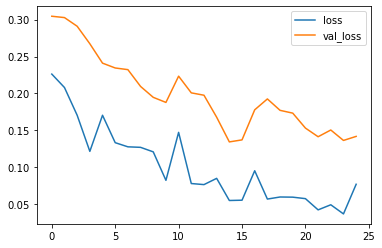

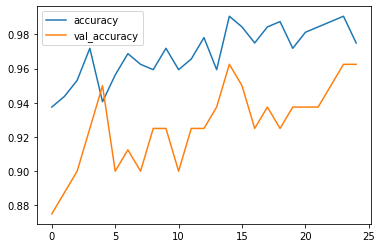

In [128]:
history_df = pd.DataFrame(history_fine.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

now we load the best model:

In [129]:
model.load_weights('save_model_xception_without_autoencoder.h5')

evaluating our model on test dataset:

In [130]:
model.evaluate(X_test*255., y_test)

4/4 [==============================] - 4s 762ms/step - loss: 0.1282 - accuracy: 0.9400


[0.1282070279121399, 0.9399999976158142]

so the final accuracy on the test dataset is 94% which is good.

now we draw some plot for the result:

first we predict the classes for test dataset:

<a name='7'></a>
# 7- evaluation

In [141]:
test_predicts = final_model.predict(X_test*255.)

In [144]:
y_predict = np.argmax(test_predicts,axis=1)

In [135]:
class_names

['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

In [134]:
test_predicts

array([4, 0, 2, 4, 0, 4, 0, 0, 2, 3, 2, 3, 2, 4, 1, 1, 1, 0, 3, 4, 2, 4,
       3, 2, 1, 2, 0, 0, 1, 4, 1, 4, 3, 2, 1, 2, 0, 0, 4, 2, 4, 0, 4, 4,
       3, 3, 2, 4, 1, 2, 2, 4, 4, 3, 4, 1, 1, 1, 2, 3, 3, 3, 3, 1, 4, 2,
       2, 1, 3, 3, 2, 0, 0, 0, 0, 3, 0, 2, 0, 1, 0, 3, 3, 2, 4, 0, 4, 2,
       4, 4, 2, 1, 3, 3, 0, 3, 1, 2, 4, 1])

In [136]:
y_test

array([4, 0, 2, 4, 0, 4, 0, 0, 2, 3, 2, 3, 2, 4, 1, 1, 1, 0, 3, 4, 1, 4,
       3, 2, 1, 2, 0, 0, 1, 4, 1, 4, 3, 2, 1, 2, 0, 0, 4, 2, 4, 3, 4, 4,
       3, 3, 2, 4, 1, 3, 2, 4, 4, 3, 4, 1, 1, 1, 2, 3, 3, 3, 3, 1, 4, 2,
       2, 1, 3, 3, 2, 0, 0, 0, 0, 3, 0, 1, 0, 2, 0, 3, 3, 2, 4, 0, 4, 2,
       4, 0, 2, 1, 3, 3, 0, 3, 1, 2, 4, 1], dtype=uint8)

visualize some prediction of our model:

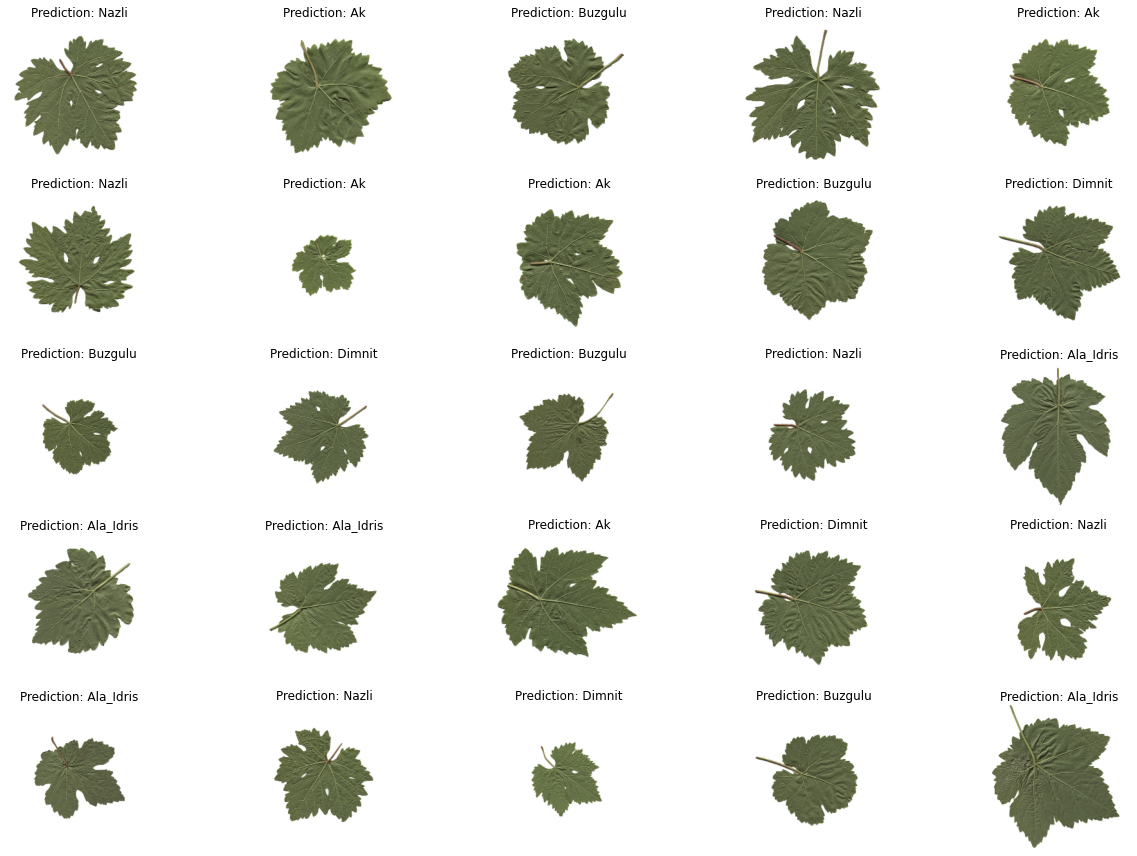

In [179]:
plt.figure(figsize=(18,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Prediction: {class_names[y_test[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

now we see the confusion matrix for our prediction:

Test set Accuracy:  0.94
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.94      0.89      0.91        18
           2       0.86      0.95      0.90        20
           3       1.00      0.91      0.95        22
           4       0.95      1.00      0.98        21

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



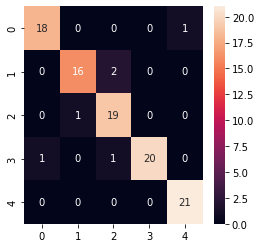

f1 is:  0.9391082357055429


In [147]:
from sklearn import metrics
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict))

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print (classification_report(y_test, y_predict))
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True)
plt.show()

from sklearn.metrics import f1_score
print('f1 is: ',f1_score(y_test, y_predict, average='macro'))

the result is clear and you can see where model doensn't predict well in the test dataset.

so at the end we see a dataframe of accuracy our models comparing to the accuracy of the article(in percentage):

In [183]:
data = [['model with autoencoder', 78], ['model without autoencoder', 94], ['model of the article', 97.6]]

df = pd.DataFrame(data, columns=['model', 'accuracy(%)'])

In [184]:
df

,model,accuracy(%)
0,model with autoencoder,78.0
1,model without autoencoder,94.0
2,model of the article,97.6


so our main model got 94% accuracy on test set and 99% accuracy on training data set which is good compare to the article which has a 97.6% accuracy.

<a name='8'></a>
# 8- Kfold

kfold operation with num_split 20. for saving time we set epochs number to 10(originally it was 13). you can see the results:

In [17]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True)

fold_no = 1
acc_per_fold=[]
loss_per_fold=[]
for train, test in kfold.split(X_train, y_train):
    
    base_model = tf.keras.applications.xception.Xception(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = True

    input_shape = (224,224,3)

    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmenter()(inputs)
    x = tf.keras.applications.xception.preprocess_input(x)
    x = base_model(x) 
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Flatten()(x)
    outputs = layers.Dense(5,activation = 'softmax')(x)

    final_model = tf.keras.Model(inputs, outputs)

    final_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    print(f'Training for fold {fold_no} ...')

    history = final_model.fit(X_train[train]*255., y_train[train],
              batch_size=16,
              epochs=10)

    scores = final_model.evaluate(X_train[test]*255., y_train[test])
    print(f'Score for fold {fold_no}: {final_model.metrics_names[0]} of {scores[0]}; {final_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

Training for fold 1 ...
Epoch 1/10
23/23 [==============================] - 53s 2s/step - loss: 1.2001 - accuracy: 0.5250
Epoch 2/10
23/23 [==============================] - 52s 2s/step - loss: 0.7150 - accuracy: 0.7417
Epoch 3/10
23/23 [==============================] - 52s 2s/step - loss: 0.7649 - accuracy: 0.7444
Epoch 4/10
23/23 [==============================] - 52s 2s/step - loss: 0.5110 - accuracy: 0.8083
Epoch 5/10
23/23 [==============================] - 52s 2s/step - loss: 0.4244 - accuracy: 0.8667
Epoch 6/10
23/23 [==============================] - 52s 2s/step - loss: 0.5142 - accuracy: 0.8222
Epoch 7/10
23/23 [==============================] - 52s 2s/step - loss: 0.3097 - accuracy: 0.9056
Epoch 8/10
23/23 [==============================] - 52s 2s/step - loss: 0.3552 - accuracy: 0.9000
Epoch 9/10
23/23 [==============================] - 52s 2s/step - loss: 0.2977 - accuracy: 0.9000
Epoch 10/10
2/2 [==============================] - 2s 289ms/step - loss: 4.0007 - accuracy: 0.

the model trained on both train and validation datasets in kfold.